In [1]:
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
torch.cuda.is_available()

True

In [4]:
from isaac.utils import plot_confusion_matrix
from isaac.dataset import read_dataset, prepare_dataset
from isaac.training import training_loop, evaluate
from isaac.models import RNNModel, ComplexRNNModel, initialise_model
from isaac.constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS, YOKED_TRAINING_COLS

In [5]:
INPUT_DIM = len(YOKED_TRAINING_COLS)    # input dimension
HIDDEN_DIM = 25  # hidden layer dimension
N_LAYERS = 3     # number of hidden layers
OUTPUT_DIM = 3   # output dimension
DROPOUT = 0.5

network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)

In [6]:
BATCH_SIZE = 256

In [7]:
def train_across_lengths(datasets, class_columns):
    train_trials, val_trials = datasets
    
    num_epochs = 100
    lengths = [1801, 1201, 601]

    all_loss = []
    all_acc = []

    for seq_length in lengths:
        sequence_loss = []
        sequence_acc = []

        loaders, _ = prepare_dataset([train_trials, val_trials], class_columns=class_columns, 
                                                      batch_size=BATCH_SIZE, normalise_data=False, 
                                     training_columns=YOKED_TRAINING_COLS
                                                      )
        train_loader, val_loader = loaders
        
        for seed in [0, 33, 72]:
            seed_loss = []
            seed_acc = []

            model, error, optimizer = initialise_model(network_dims, DROPOUT, lr=0.01, seed=seed)

            seed_loss, seed_acc, _ = training_loop(model, optimizer, error, train_loader, val_loader, num_epochs,
                                                print_stats_per_epoch=False, seq_end=seq_length)
            
            sequence_loss.append(seed_loss)
            sequence_acc.append(seed_acc[1])
        all_loss.append(sequence_loss)
        all_acc.append(sequence_acc)
    
    return all_loss, all_acc

In [8]:
def plot_timeseries(timeseries, labels):
    plt.figure(figsize=(11, 7))
    for length, ts_item in zip(labels, timeseries):
        plt.errorbar(np.arange(timeseries.shape[-1]), ts_item.mean(axis=0), yerr=ts_item.std(axis=0), 
                     label=str(length))
    plt.legend()

# MASS TRIALS

In [9]:
exp1_trials = read_dataset("data/yoked_trials_exp1.h5")
exp2_mass_trials = read_dataset("data/mass_trials_exp2.h5")
exp2_force_trials = read_dataset("data/force_trials_exp2.h5")

first_half = [trial[:1801] for trial in exp1_trials]
second_half = [trial[-1801:] for trial in exp1_trials]

exp1_trials = first_half + second_half

yoked_trials = exp1_trials + exp2_force_trials + exp2_mass_trials

100%|██████████| 399/399 [00:06<00:00, 61.98it/s]


In [10]:
np.random.seed(0)
indices = np.arange(len(yoked_trials))
test_indices = np.random.choice(indices, 200, replace=False)
train_indices = list(set(indices) - set(test_indices))

train_trials = [yoked_trials[i] for i in train_indices]
test_trials = [yoked_trials[i] for i in test_indices]

In [11]:
all_loss, all_acc = train_across_lengths([train_trials, test_trials], MASS_CLASS_COLS)

all_loss = np.array(all_loss)
all_acc = np.array(all_acc)

100%|██████████| 100/100 [01:40<00:00,  1.01s/it]


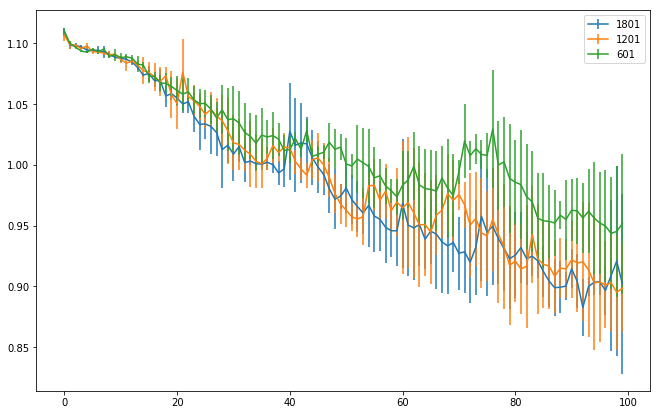

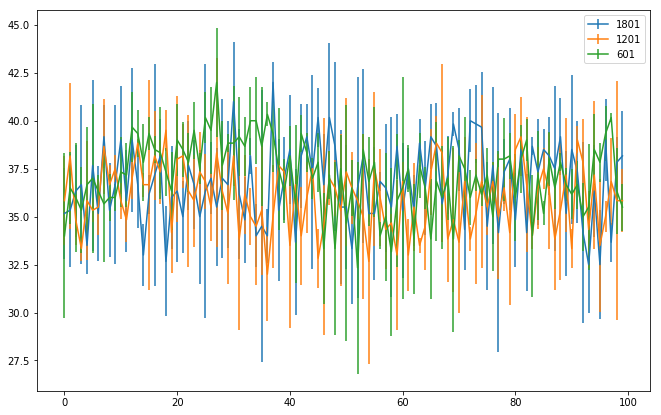

In [12]:
lengths = [1801, 1201, 601]
plot_timeseries(all_loss, lengths)
plot_timeseries(all_acc, lengths)

# FORCE

In [13]:
all_loss, all_acc = train_across_lengths([train_trials, test_trials], FORCE_CLASS_COLS)

all_loss = np.array(all_loss)
all_acc = np.array(all_acc)

100%|██████████| 3000/3000 [00:15<00:00, 199.72it/s]


ValueError: too many values to unpack (expected 2)

In [ ]:
plot_timeseries(all_loss, lengths)
plot_timeseries(all_acc, lengths)